In [ ]:
!pip install plotly-express

In [217]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType,DoubleType,DateType
import pandas as pd
from pyspark.sql.functions import acos, cos, sin, lit, toRadians

from pyspark.sql.window import Window
from pyspark.sql.functions import lag
from datetime import datetime
import plotly.express as px

In [229]:
spark = SparkSession.builder.master("local").appName("regr").getOrCreate()
sc = spark.sparkContext
sql = SQLContext(sc)

df = spark.read.parquet('./data/masterdf.parquet')
df = df.drop('Condition')
df = df.withColumn('Time',F.to_timestamp(F.col('Time'), 'yyyy-MM-dd HH:mm:ss').alias('Time'))
df = df.dropDuplicates(['Time','VehicleNumber'])
df = df.withColumn('last_updated_epoch',F.from_unixtime(F.col('last_updated_epoch').cast('string')))

time_limit = datetime.now()
time_limit = time_limit.replace(minute=0, second=0, microsecond=0)
df = df.filter(F.col('Time') < F.to_timestamp(F.lit(time_limit)))


def dist(long_x, lat_x, long_y, lat_y):
    return acos(
        sin(toRadians(lat_x)) * sin(toRadians(lat_y)) + 
        cos(toRadians(lat_x)) * cos(toRadians(lat_y)) * 
            cos(toRadians(long_x) - toRadians(long_y))
    ) * lit(6371000.0)

w = Window().partitionBy("VehicleNumber").orderBy("time")



df = df.withColumn("dist", dist(
    "Lon", "Lat",
    F.lag("Lon", 1).over(w), F.lag("Lat", 1).over(w)
).alias("dist"))
df = df.withColumn('timedelta',F.col('time').cast('long') - F.lag('time',1).over(w).cast('long'))

df = df.withColumn('speed',3.6*(F.col('dist')/ F.col('timedelta')))
df = df.dropna()

In [230]:
df.show()

+-----+----------+-------------+-------------------+----------+-------+-------------------+----------------+------+------+------+--------+--------+-----------+--------+-----------+-----------+---------+---------+--------+-----+-----------+-----------+------+---------+---+--------+--------+-------------+------------------+---------+--------------------+
|Lines|       Lon|VehicleNumber|               Time|       Lat|Brigade| last_updated_epoch|    last_updated|temp_c|temp_f|is_day|wind_mph|wind_kph|wind_degree|wind_dir|pressure_mb|pressure_in|precip_mm|precip_in|humidity|cloud|feelslike_c|feelslike_f|vis_km|vis_miles| uv|gust_mph|gust_kph|          key|              dist|timedelta|               speed|
+-----+----------+-------------+-------------------+----------+-------+-------------------+----------------+------+------+------+--------+--------+-----------+--------+-----------+-----------+---------+---------+--------+-----+-----------+-----------+------+---------+---+--------+--------+

In [231]:
df.count()

103888

In [232]:
df.columns

['Lines',
 'Lon',
 'VehicleNumber',
 'Time',
 'Lat',
 'Brigade',
 'last_updated_epoch',
 'last_updated',
 'temp_c',
 'temp_f',
 'is_day',
 'wind_mph',
 'wind_kph',
 'wind_degree',
 'wind_dir',
 'pressure_mb',
 'pressure_in',
 'precip_mm',
 'precip_in',
 'humidity',
 'cloud',
 'feelslike_c',
 'feelslike_f',
 'vis_km',
 'vis_miles',
 'uv',
 'gust_mph',
 'gust_kph',
 'key',
 'dist',
 'timedelta',
 'speed']

## Ilość jeżdżących pojazdów oraz ilość linii

In [57]:
df.select('VehicleNumber').distinct().count()

860

In [58]:
df.select('Lines').distinct().count()

208

# Ilość rekordów per godzina

In [48]:
df.withColumn('hour',F.hour('Time')).groupBy('hour').count().orderBy(F.asc('hour')).show()

+----+------+
|hour| count|
+----+------+
|  11| 10464|
|  12|178499|
|  13| 15133|
+----+------+



# Ilość działających autobusów per godzina

In [61]:
df.withColumn('hour',F.hour('Time')).groupBy('hour').agg(F.countDistinct('VehicleNumber')).orderBy(F.asc('hour',)).show()

+----+--------------------+
|hour|count(VehicleNumber)|
+----+--------------------+
|  11|                 841|
|  12|                 856|
|  13|                 847|
+----+--------------------+



# Ilość wpisów autobusów per update pogody

In [80]:
df.groupBy('last_updated_epoch').count().orderBy('count').show()

+-------------------+-----+
| last_updated_epoch|count|
+-------------------+-----+
|2022-01-15 10:45:00| 8330|
|               null|15906|
|2022-01-15 11:30:00|80746|
|2022-01-15 11:00:00|96678|
+-------------------+-----+



# Ilość autobusów per linia (która linia jest najbardziej oblegana przez autobusy)

In [94]:
df.select(['Lines','VehicleNumber']).groupBy('Lines').agg(F.countDistinct('VehicleNumber')).orderBy(F.desc('count(VehicleNumber)')).show()


+-----+--------------------+
|Lines|count(VehicleNumber)|
+-----+--------------------+
|  190|                  16|
|  189|                  14|
|  523|                  14|
|  112|                  12|
|  116|                  11|
|  180|                  11|
|  136|                  11|
|  114|                  10|
|  175|                  10|
|  141|                   9|
|  Z10|                   9|
|  509|                   9|
|  142|                   9|
|  148|                   9|
|  186|                   9|
|  709|                   9|
|  128|                   9|
|  166|                   8|
|  185|                   8|
|  138|                   8|
+-----+--------------------+
only showing top 20 rows



# Zachowanie autobusu numer 7253

In [233]:
bus_7253 = df.filter(F.col('VehicleNumber') == 7253)
px.line(bus_7253.toPandas(),x='Time',y='speed').write_html('./data/7253.html')

In [ ]:
fig = px.scatter_mapbox(bus_7253.toPandas(), lat="Lat", lon="Lon",color='speed', hover_name="Lines",color_continuous_scale=px.colors.sequential.matter, size_max=20,
                        zoom=5, mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html('./data/7253_speed.html')

#  Najszybszy skurwol w mieście

In [172]:
df.dropna().groupBy('VehicleNumber').agg(F.avg('speed')).orderBy(F.desc('avg(speed)')).show()

+-------------+------------------+
|VehicleNumber|        avg(speed)|
+-------------+------------------+
|         8579|  30.0140541957777|
|         4211| 29.52764125354322|
|        70592|29.437048011807498|
|        15612|28.914658016997645|
|        15617|28.409983410756315|
|         8454|28.023488626870968|
|         4309|27.919873112611803|
|        36444|27.590029497614438|
|         2253|26.217234356043342|
|         9427|25.560525039033415|
|         7739|25.482615178708212|
|         9429| 25.41201766789583|
|         9452| 25.34812520942227|
|        80635| 25.02675430775333|
|         1013| 24.82675371481225|
|         8307|24.384459433954664|
|         3468|24.314326077427662|
|         3439| 24.25214511824165|
|         1530| 24.19056609232398|
|        80637|24.150769935558085|
+-------------+------------------+
only showing top 20 rows



# Najszybsza linia w mieście

In [173]:
df.dropna().groupBy('Lines').agg(F.avg('speed')).orderBy(F.desc('avg(speed)')).show()

+-----+------------------+
|Lines|        avg(speed)|
+-----+------------------+
|  720|  30.0140541957777|
|  733| 29.52764125354322|
|  L-3|28.611063425229794|
|  730|27.919873112611803|
|  L17|27.590029497614438|
|  L32|26.614515302129913|
|  703|26.217234356043342|
|  743| 25.34812520942227|
|  L24| 25.34229690846931|
|  L15| 25.04329680926244|
|  L45| 25.02675430775333|
|  L35|24.150769935558085|
|  L-8|24.010461700740578|
|  736|23.911772572772804|
|  707| 23.27967726927678|
|  L11|23.188986760109017|
|  L40|  23.0896330442291|
|  L10| 22.29460142116601|
|  722| 21.96020988551708|
|  132| 21.72192964021085|
+-----+------------------+
only showing top 20 rows



# Opady a srednia predkosc w godzinie

In [177]:
df.withColumn('hour',F.hour('Time')).dropna().groupBy('hour').agg(F.avg('speed'),F.avg('precip_mm')).orderBy(F.desc('hour')).show()

+----+------------------+--------------+
|hour|        avg(speed)|sum(precip_mm)|
+----+------------------+--------------+
|  12|15.509879980460525|           0.0|
|  11|15.298592977767958|           0.0|
+----+------------------+--------------+



# Temperatura a srednia predkosc w godzinie

In [235]:
df.withColumn('hour',F.hour('Time')).groupBy('hour').agg(F.avg('speed'),F.avg('temp_c')).orderBy(F.desc('hour')).show()

+----+------------------+-----------+
|hour|        avg(speed)|avg(temp_c)|
+----+------------------+-----------+
|  12|15.509879980460525|        2.0|
|  11|15.298592977767958|        1.0|
+----+------------------+-----------+



# Heatmapa autobusów overall

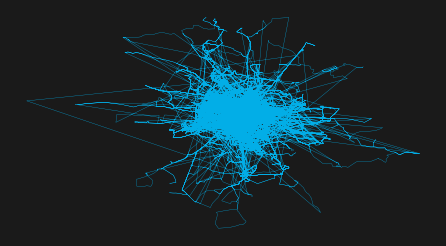

In [240]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df_pan = df.toPandas()

fig = plt.figure(facecolor = '0.1')
ax = plt.Axes(fig, [0., 0., 1., 1.], )
ax.set_aspect('equal')
ax.set_axis_off()
fig.add_axes(ax)
plt.plot(df_pan['Lon'], df_pan['Lat'], color = 'deepskyblue', lw = 0.3, alpha = 0.9)
plt.show()